### Define Circuit

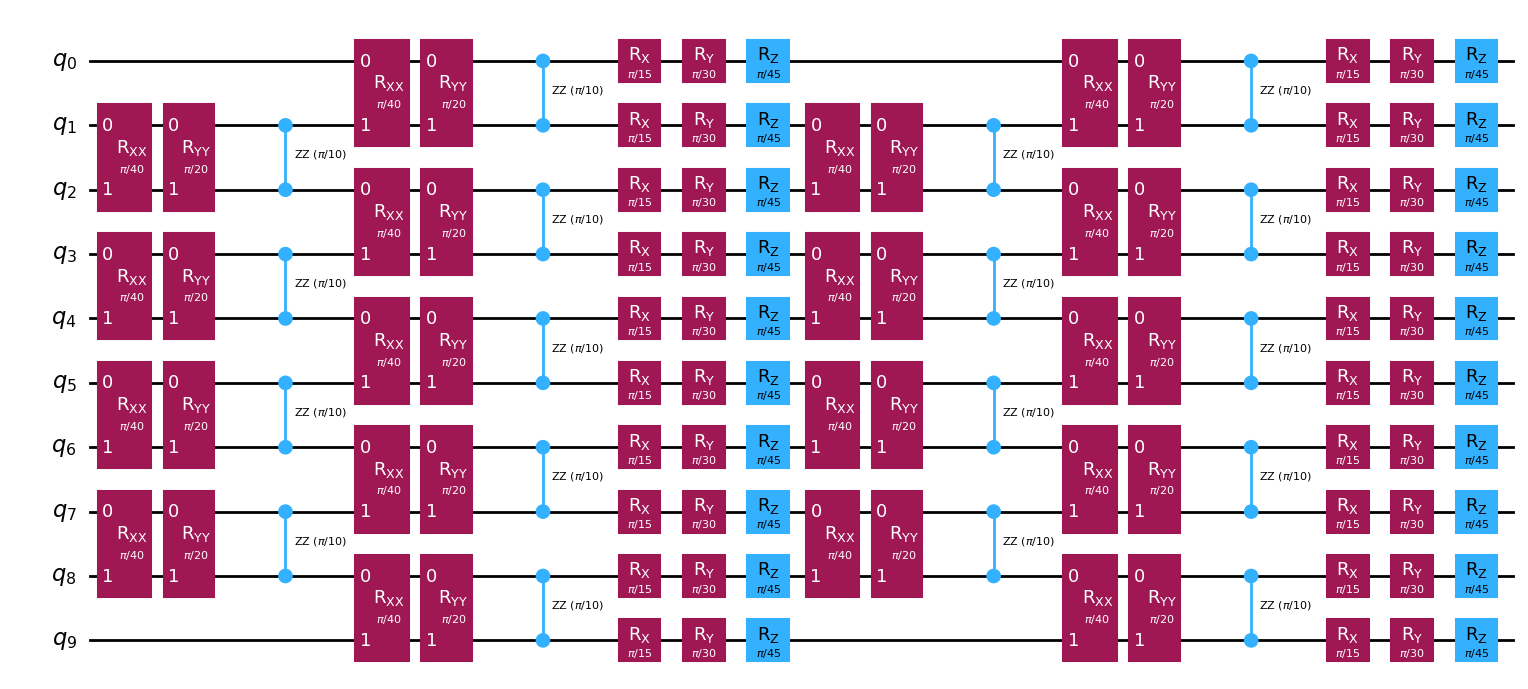

In [15]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)

circuit.draw("mpl")

### Define Observable

In [16]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])


### Define Backend

In [17]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeKolkataV2()

In [18]:
truncation_error_budget_list =[] # The list of errors to be used 
max_error_per_slice_list = np.linspace(0.0001,0.02,20)
for error in max_error_per_slice_list:
    trunc_budget = setup_budget(max_error_per_slice=error)
    truncation_error_budget_list.append(trunc_budget)
print(truncation_error_budget_list)

[TruncationErrorBudget(per_slice_budget=[np.float64(0.0001)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0011473684210526317)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.002194736842105263)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0032421052631578947)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.004289473684210527)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.005336842105263159)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.00638421052631579)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.007431578947368422)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.008478947368421

In [19]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)

### Synthesize circ0, the original experiment (Synthesized circuit with no OBP)

In [20]:
circ0 = pm.run(circuit)
print(" The depth of the circuit with no OBP is : ",circ0.depth() )

 The depth of the circuit with no OBP is :  41


In [21]:
# Define an operator budget
op_budget = OperatorBudget(max_qwc_groups=8)

# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(circ0, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 41 slices.


### Define circ1, the backpropagated circuit with no truncation

In [22]:
# Backpropagate without the truncation error budget
backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
)
# Recombine the slices remaining after backpropagation
circ1 = combine_slices(remaining_slices, include_barriers=False)

print(f"Depth of the backpropagated circuit with no truncation is: ", circ1.depth())

Depth of the backpropagated circuit with no truncation is:  27


In [9]:
#backpropagated_observable.group_commuting()

### Define circ2, circ3, circ4 which are backpropagated circuits with 3 different truncation errors (anomaly point)

In [23]:
truncated_circs = []
truncated_observables=[]
# Backpropagate *with* the truncation error budget
for err in truncation_error_budget_list:
    backpropagated_observable_trunc, remaining_slices_trunc, metadata_trunc = backpropagate(
            observable,
            synthesized_slices,
            operator_budget=op_budget,
            truncation_error_budget=err,
        )
    #truncated_circuits_list.append(remaining_slices_trunc)

# Recombine the slices remaining after backpropagation
    bp_circuit_trunc = combine_slices(
        remaining_slices_trunc, include_barriers=False
    )
    if bp_circuit_trunc != None:
        truncated_circs.append(bp_circuit_trunc)
    else:
        bp_circuit_trunc = QuantumCircuit(circuit.num_qubits)
        truncated_circs.append(bp_circuit_trunc)
    truncated_observables.append(backpropagated_observable_trunc) # truncated observables appended
#print(truncated_circs)
    #bp_circuit_trunc.draw("mpl")
#print(truncated_observables)




for truncated_circ in truncated_circs:
    if truncated_circ != None:
        print(f"Depth of the truncated backpropagated circuit is: ", truncated_circ.depth())
    else:
        print(f"Depth of the truncated backpropagated circuit is: ", 0)



Depth of the truncated backpropagated circuit is:  27
Depth of the truncated backpropagated circuit is:  27
Depth of the truncated backpropagated circuit is:  27
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  14
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  5
Depth of the truncated backpr

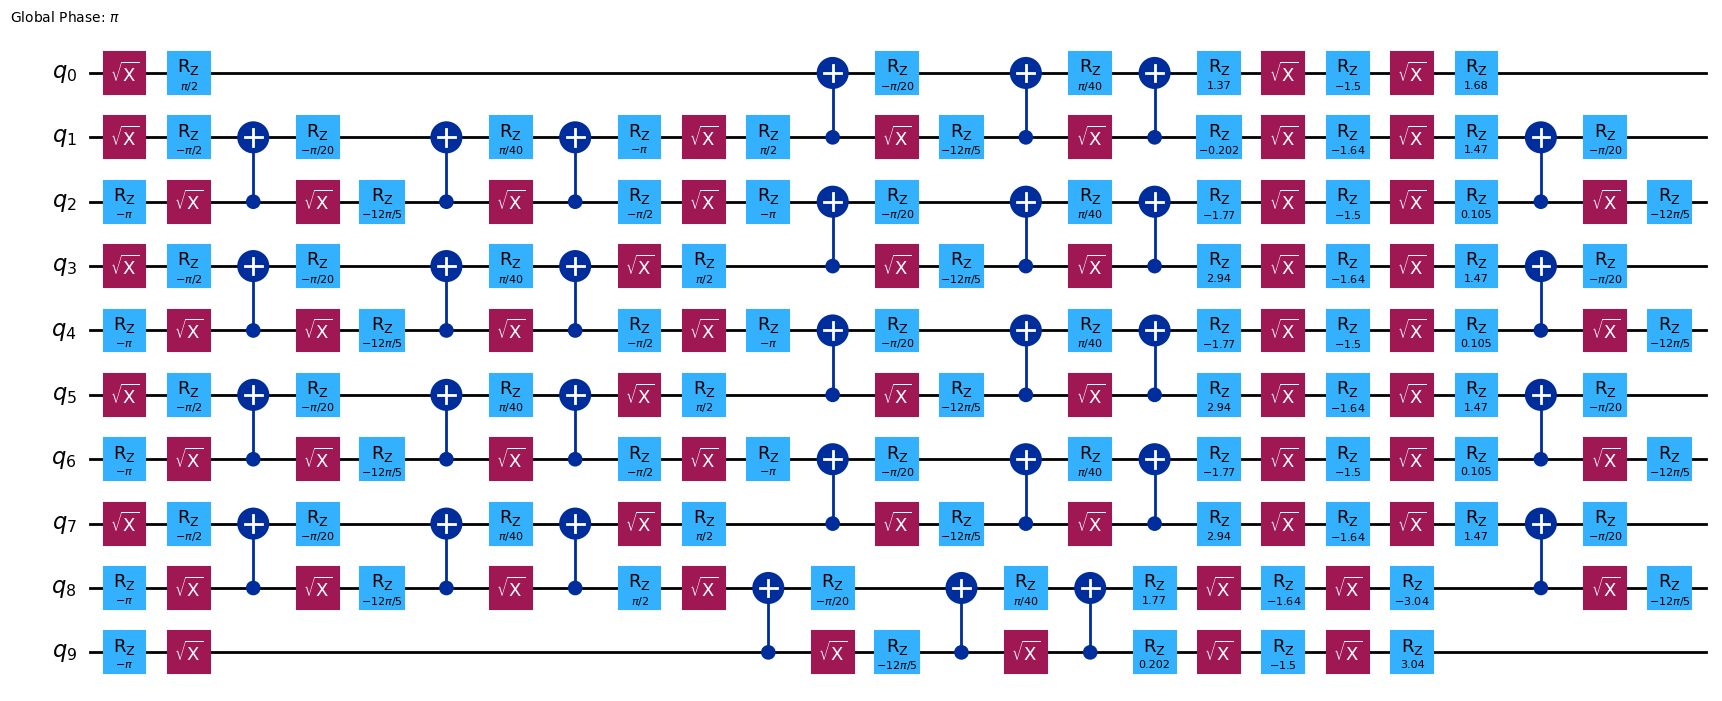

In [24]:
truncated_circs[9].draw("mpl")

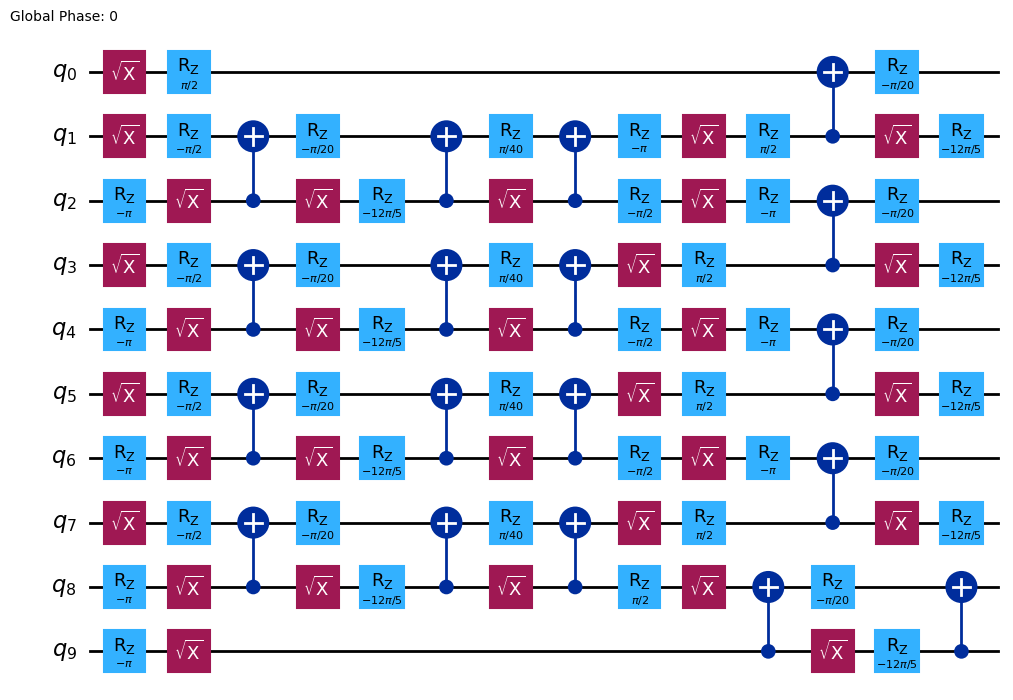

In [25]:
truncated_circs[10].draw("mpl")

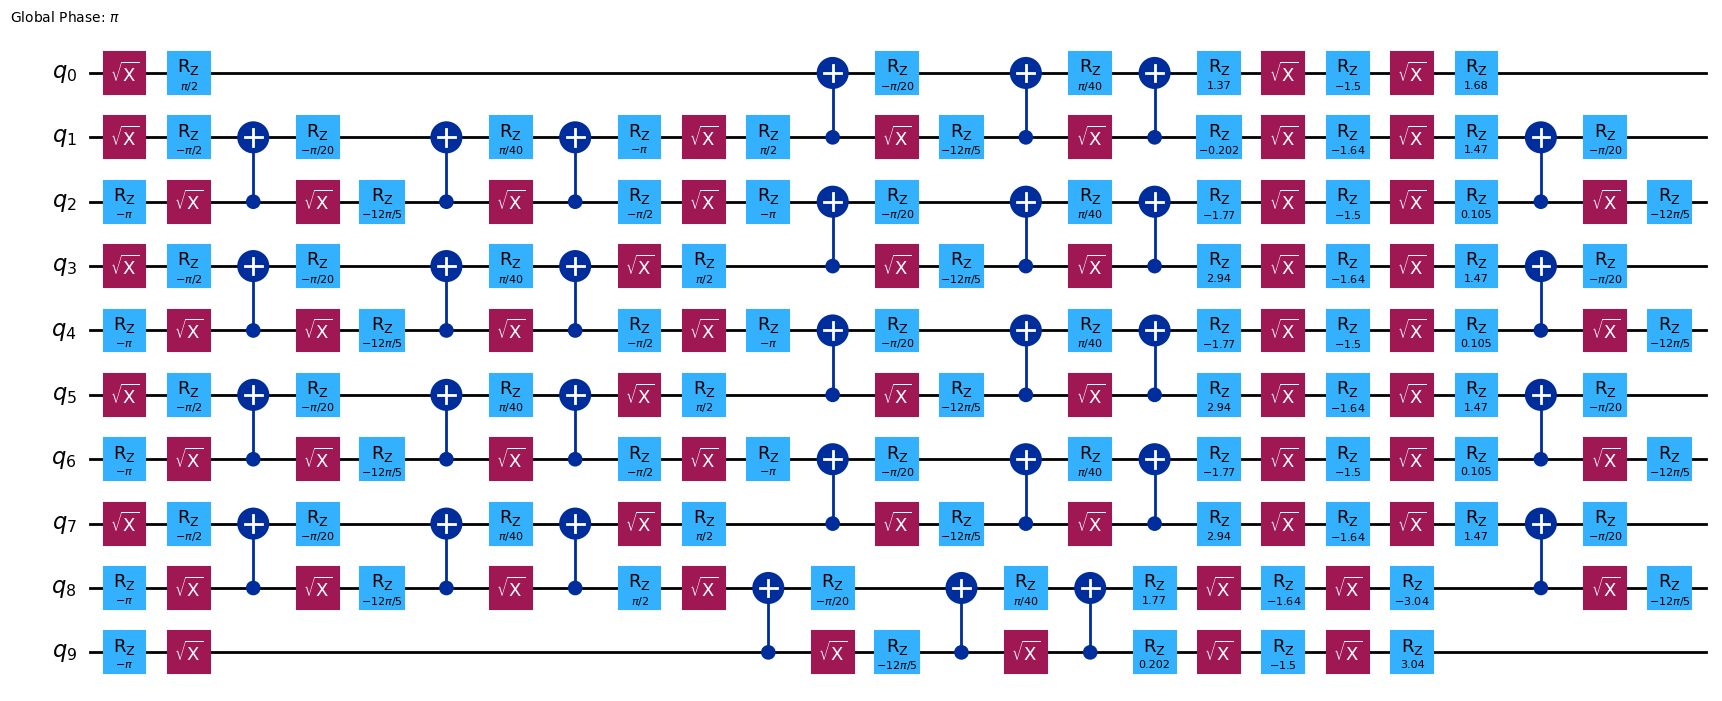

In [26]:
truncated_circs[11].draw("mpl")

In [27]:
truncated_circs_isa=[]
observable_truncated_circs_isa =[]
truncated_circuit_depths = []
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)

circ0_isa =pass_manager.run(circ0)
observable_isa_circ0 = observable.apply_layout(circ0_isa.layout)
truncated_circuit_depths.append(circ0.depth())
circ1_isa =pass_manager.run(circ1)
observable_isa_circ1 = backpropagated_observable.apply_layout(circ1_isa.layout)
truncated_circuit_depths.append(circ1.depth())
for ckt,trunc_obs in zip(truncated_circs,truncated_observables):
        truncated_circ_isa = pass_manager.run(ckt)
        observable_isa_trunc_circ = trunc_obs.apply_layout(truncated_circ_isa.layout)
        truncated_circs_isa.append(truncated_circ_isa)
        observable_truncated_circs_isa.append(observable_isa_trunc_circ)

for truncated_ckt in truncated_circs_isa:
    if truncated_ckt != None:
        depth = truncated_ckt.depth()
        truncated_circuit_depths.append(depth)
    else:
        truncated_circuit_depths.append(0)

print(truncated_circuit_depths)



[41, 27, 27, 27, 27, 25, 25, 25, 25, 25, 25, 25, 14, 25, 25, 25, 25, 25, 25, 5, 5, 0]


In [ ]:
# 0.014763157894736843
# 0.015810526315789476
# 0.016857894736842106

In [28]:
estimator_ideal = EstimatorV2(mode=AerSimulator())
result_ideal =(
    estimator_ideal.run([(circ0_isa, observable_isa_circ0)]).result()[0].data.evs.item()
)
print("The ideal expectation value is : ", result_ideal)

The ideal expectation value is :  0.886083984375


In [29]:
job =[]
with Batch(backend=backend) as batch:
    estimator=EstimatorV2(mode=batch)
    pub0 = (circ0_isa,observable_isa_circ0)
    job0=estimator.run([pub0,pub0,pub0,pub0,pub0])
    job.append(job0)

    pub1 = (circ1_isa,observable_isa_circ1)
    job1=estimator.run([pub1,pub1,pub1,pub1,pub1])
    job.append(job1)

    for circ_err,obs_err in zip(truncated_circs_isa, observable_truncated_circs_isa):
        puberr= (circ_err,obs_err)
        job_err = estimator.run([puberr,puberr,puberr,puberr,puberr])
        job.append(job_err)


In [30]:
batch_id = batch.session_id
print(batch_id)

None


In [31]:
batch.status()

In [32]:
job[0].result()[0].data.evs.item()

0.7958984375

In [33]:
exp_vals = []
for j in job:
    exp_vals.append((j.result()[0].data.evs.item(),
                      j.result()[1].data.evs.item(),
                      j.result()[2].data.evs.item(),
                      j.result()[3].data.evs.item(),
                      j.result()[4].data.evs.item()))
print(exp_vals)

[(0.7958984375, 0.79990234375, 0.79462890625, 0.7983886718750002, 0.7989257812500001), (0.8144131840730621, 0.8147059225263714, 0.813344463971064, 0.8112973284985128, 0.8136308081503725), (0.814414247688424, 0.8167900455868247, 0.8147439426000425, 0.8173917361341092, 0.8118197849054065), (0.8160411080396026, 0.8141414440444603, 0.8159789587063736, 0.8137095003041697, 0.8157365056723773), (0.8168692923052149, 0.8162877369293352, 0.8165726635215825, 0.8150894281558604, 0.8220390968365546), (0.82931111811843, 0.8294979699147301, 0.8224655874290642, 0.8246213301128837, 0.8257109559476874), (0.8252922126000832, 0.8267193605537311, 0.8249930331887493, 0.8243456155376155, 0.8292707791730655), (0.8216712529792025, 0.8264606734808302, 0.8277161451098598, 0.8233790001982607, 0.830199937767987), (0.8265451394064856, 0.8278015029564884, 0.8246734144119569, 0.8287273782616217, 0.826662943409153), (0.8272440266897374, 0.8281573749161568, 0.8293844892102167, 0.8282033379327775, 0.8221353813731573), (

In [ ]:
# 0.0001
# 0.0011473684210526317
# 0.002194736842105263
# 0.0032421052631578947
# 0.004289473684210527
# 0.005336842105263159
# 0.00638421052631579
# 0.007431578947368422
# 0.008478947368421053
# 0.009526315789473685
# 0.010573684210526317
# 0.011621052631578949
# 0.012668421052631579
# 0.01371578947368421
# 0.014763157894736843
# 0.015810526315789476
# 0.016857894736842106
# 0.017905263157894737
# 0.01895263157894737
# 0.02

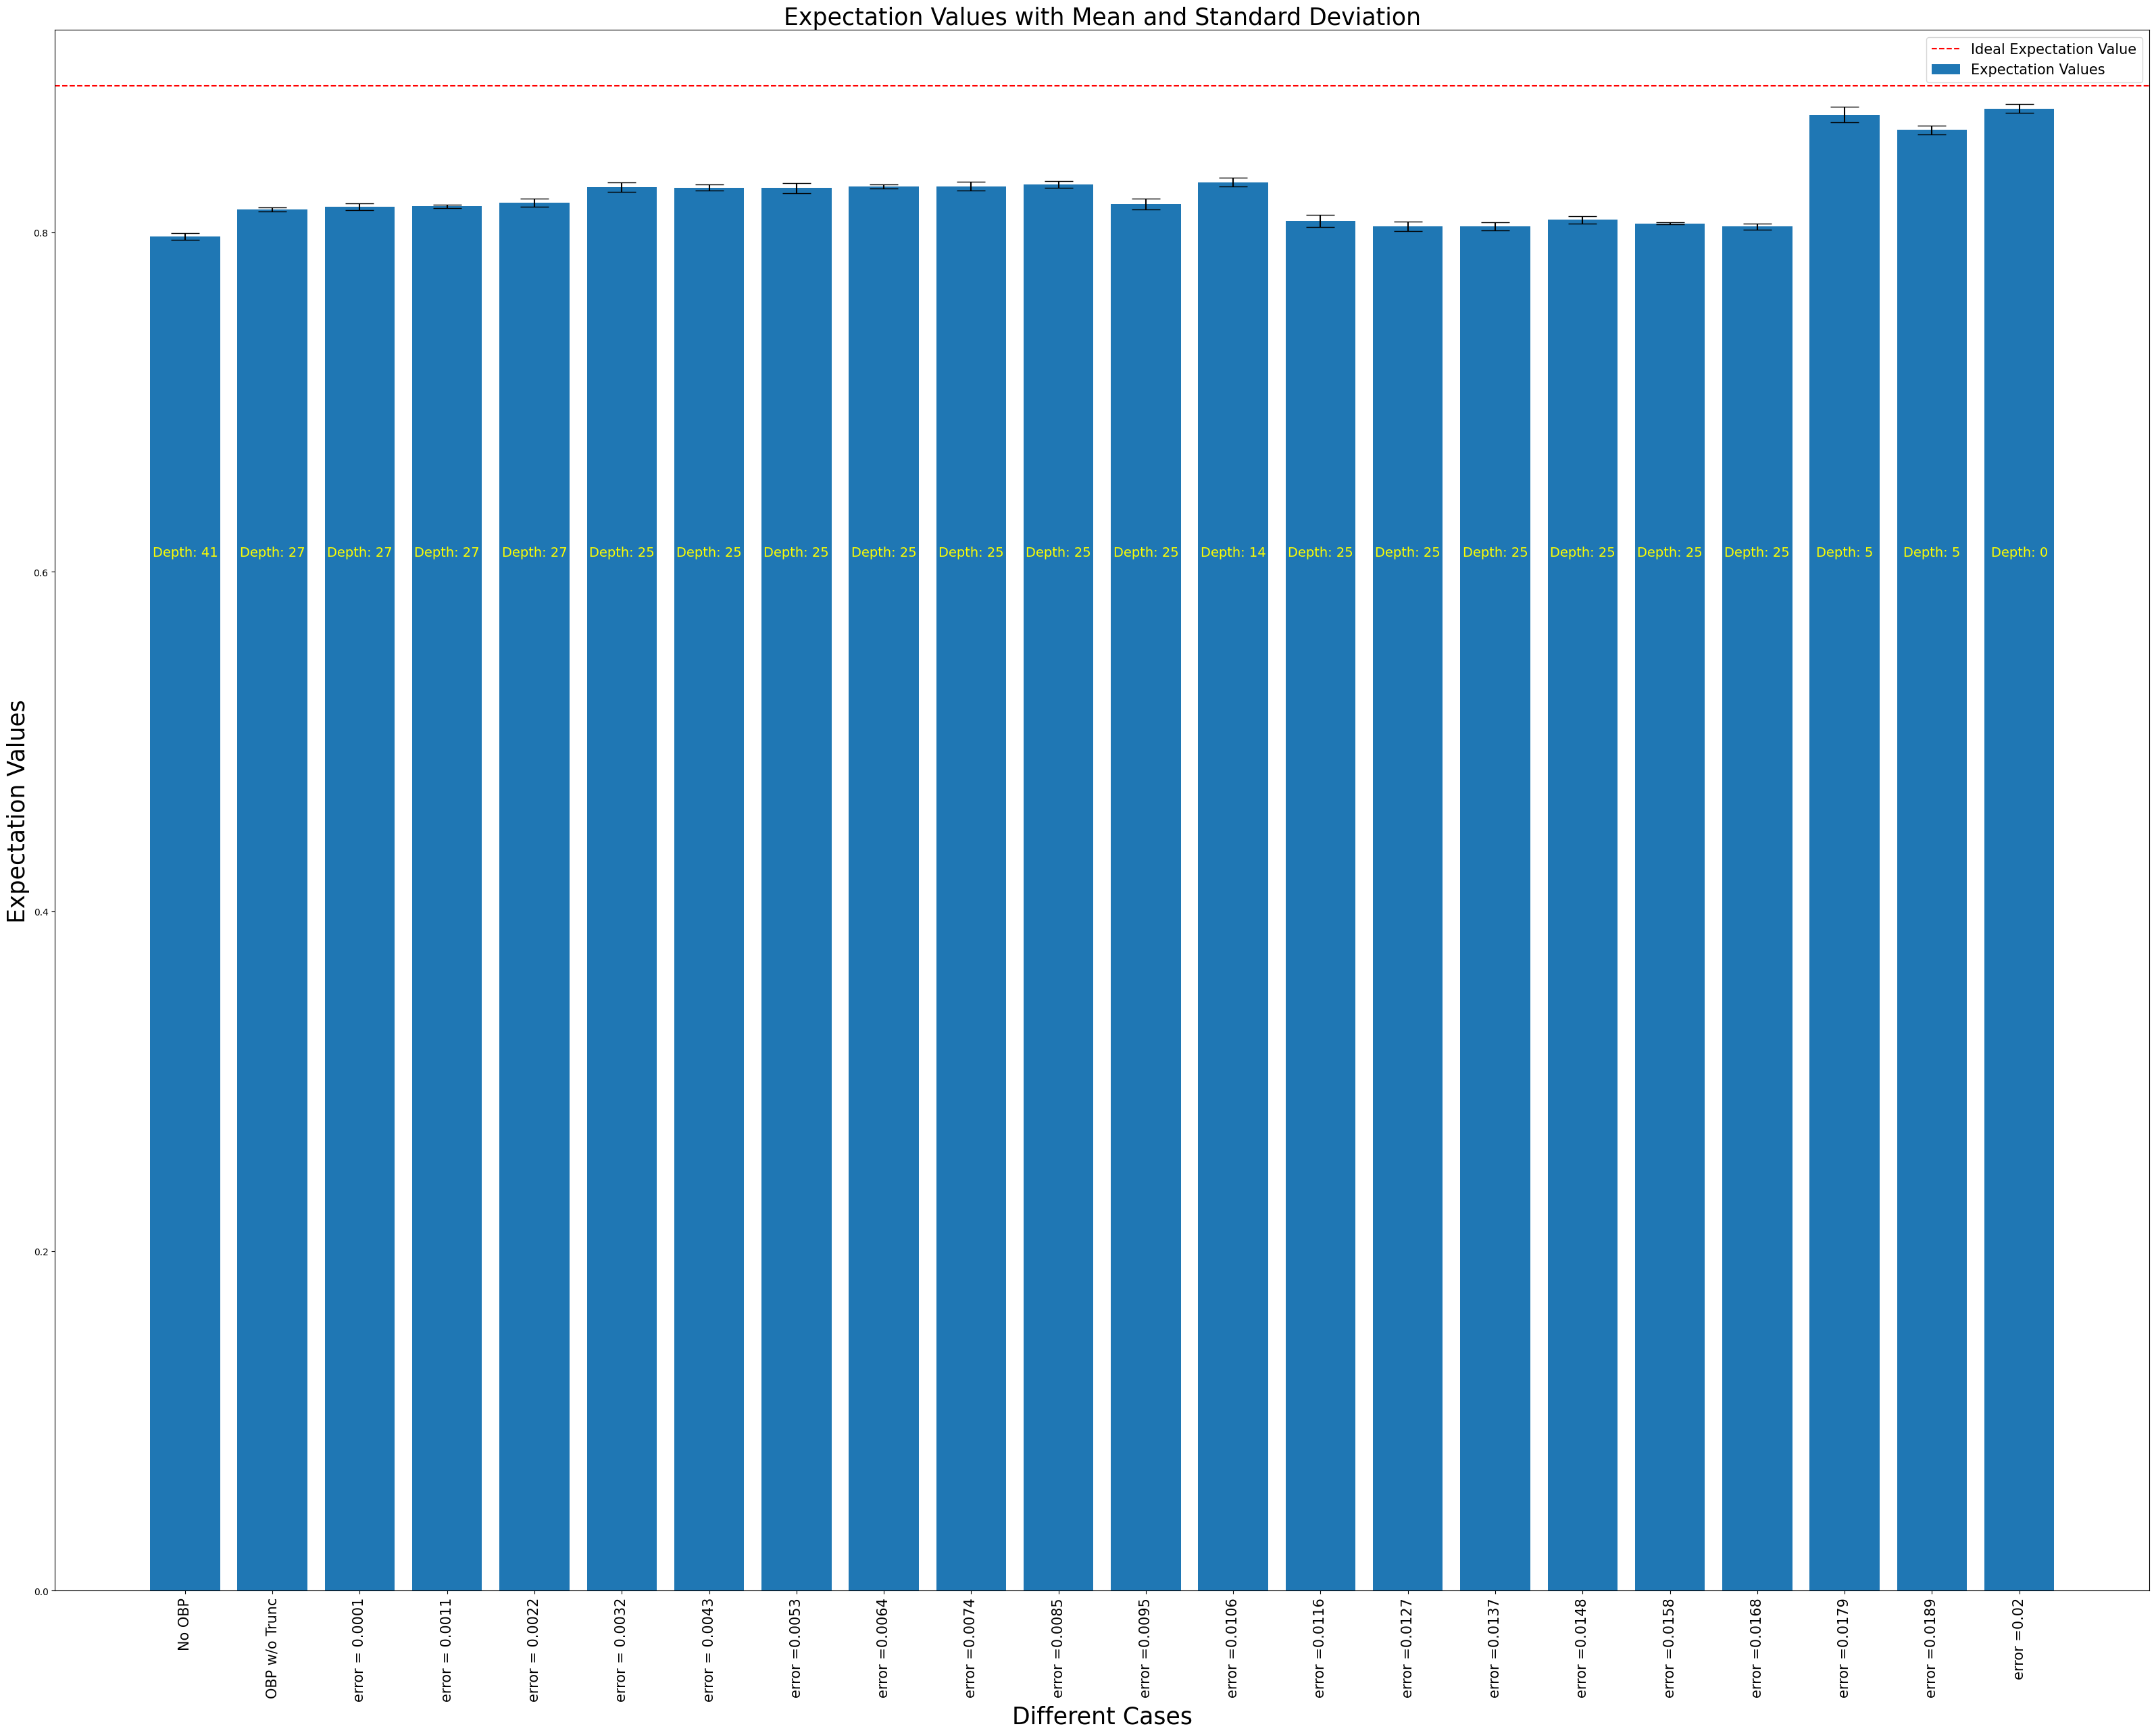

In [34]:
import matplotlib.pyplot as plt
import numpy as np

means = [np.mean(t) for t in exp_vals]
std_devs = [np.std(t) for t in exp_vals]
#print(means)

bar_lengths = means
error_bars = std_devs

#x_pos = np.arange(1, 23)
fig, ax = plt.subplots(figsize=(40,30))
labels=['No OBP', 'OBP w/o Trunc', 'error = 0.0001','error = 0.0011', 'error = 0.0022','error = 0.0032', 'error = 0.0043', 'error =0.0053', 'error =0.0064','error =0.0074','error =0.0085','error =0.0095','error =0.0106','error =0.0116','error =0.0127','error =0.0137','error =0.0148','error =0.0158','error =0.0168','error =0.0179','error =0.0189','error =0.02']
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=15)

x_pos = range(len(labels))  # same length as your data
ax.bar(x_pos, bar_lengths, yerr=error_bars, capsize=15, label='Expectation Values')
for i, depth in enumerate(truncated_circuit_depths):
    ax.text(x_pos[i], 0.615, f'Depth: {int(depth)}', ha='center', va='top', fontsize=14, color='yellow')
ax.set_xlabel("Different Cases", fontsize=25)
ax.set_ylabel("Expectation Values", fontsize=25)
ax.set_title("Expectation Values with Mean and Standard Deviation", fontsize=25)
plt.axhline(y=result_ideal, color='r', linestyle='--', label='Ideal Expectation Value')
plt.legend(fontsize=15)
plt.show()
